In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
# read all the words
words = open("names.txt", "r").read().splitlines()
print("total number of words : ", len(words))


total number of words :  32033


In [8]:
# build the vocablury
chars = sorted(list(set("".join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi["."] = 0
itos = {i:s for s, i in stoi.items()}
vocab_size = len(itos)
print("vocab size : ", vocab_size)


vocab size :  27


In [9]:
# shuffle the words
import random
random.seed(42)
random.shuffle(words)

In [11]:
# build the dataset
block_size = 3

def build_dataset(words):
    x, y = [], []
    
    for w in words:
        context = [0] * block_size
        for ch in w + ".":
            ix = stoi[ch]
            x.append(context)
            y.append(ix)
            context = context[1:] + [ix]
    x = torch.tensor(x)
    y = torch.tensor(y)

    return x, y

n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

xtr, ytr = build_dataset(words[:n1])
xdev, ydev = build_dataset(words[n1:n2])
xte, yte = build_dataset(words[n2:])


In [62]:
# Layer modules

g = torch.Generator().manual_seed(2147483647)

class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weights = torch.randn((fan_in, fan_out))
        self.bias = torch.randn((fan_out)) if bias else None

    def __call__(self, x):
        self.out = x @ self.weights
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        if self.bias is None:
            return [self.weights]
        return [self.weights, self.bias]
    
class BatchNorm1d:
    def __init__(self, dim, eps = 1e-5, momentum = 0.1):
        self.eps = eps
        self.momentum = momentum
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        self.training = True
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        if self.training:
            xmean = x.mean(0, keepdim=True)
            xvar = x.var(0, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var

        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta

        # update the buffers:
        if self.training:
            self.running_mean = self.momentum * xmean + (1 - self.momentum) * self.running_mean
            self.running_var = self.momentum * xvar + (1 - self.momentum) * self.running_var

        return self.out
        
    def parameters(self):
        return [self.gamma, self.beta]
    

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []
    
class Embedding:
    def __init__(self, num_emb, emb_dim):
        self.weight = torch.randn(num_emb, emb_dim)

    def __call__(self, IX):
        self.out = self.weight[IX]
        return self.out

    def parameters(self):
        return [self.weight]
    
class Flatten:
    def __call__(self, x):
        self.out = x.view(x.shape[0], -1)
        return self.out
    
    def parameters(self):
        return []
    

class Sequential:
    def __init__(self, layers):
        self.layers = layers
        self.layers[-1].weights *= 0.1

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]




In [63]:
torch.manual_seed(42)

n_emb = 10
n_hidden = 200

model = Sequential([
    Embedding(vocab_size, n_emb), Flatten(),
    Linear(n_emb * block_size, n_hidden, bias = False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size)
])

parameters = model.parameters()
print("Total params : ", sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True


Total params :  12097


In [64]:
# same optimization as last time

max_steps = 200000
batch_size = 32
losses = []
ud = []


for i in range(max_steps):

    # minibatch calculation
    ix = torch.randint(0, xtr.shape[0], (batch_size, ))
    xb, yb = xtr[ix], ytr[ix]

    # forward pass
    logits = model(xb)
    loss = F.cross_entropy(logits, yb)

    # backward pass
    for p in parameters:
        p.grad = None
    
    loss.backward()

    # update of parameters
    lr = 0.1 if i < 100000 else  0.01
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    losses.append(loss.item())
    ud.append([(lr*p.grad.std() / p.data.std()).log10().item() for p in parameters])

    if i % 10000 == 0:
        print(f"{i} / {max_steps} : loss = {loss:.4f}")



0 / 200000 : loss = 4.3399
10000 / 200000 : loss = 2.3501
20000 / 200000 : loss = 2.2011
30000 / 200000 : loss = 2.0908
40000 / 200000 : loss = 2.6488
50000 / 200000 : loss = 2.0019
60000 / 200000 : loss = 1.9146
70000 / 200000 : loss = 2.4571
80000 / 200000 : loss = 2.2702
90000 / 200000 : loss = 2.2321
100000 / 200000 : loss = 2.3930
110000 / 200000 : loss = 2.2353
120000 / 200000 : loss = 1.8182
130000 / 200000 : loss = 2.1392
140000 / 200000 : loss = 2.4560
150000 / 200000 : loss = 2.1819
160000 / 200000 : loss = 1.9956
170000 / 200000 : loss = 2.0607
180000 / 200000 : loss = 2.0816
190000 / 200000 : loss = 1.7335


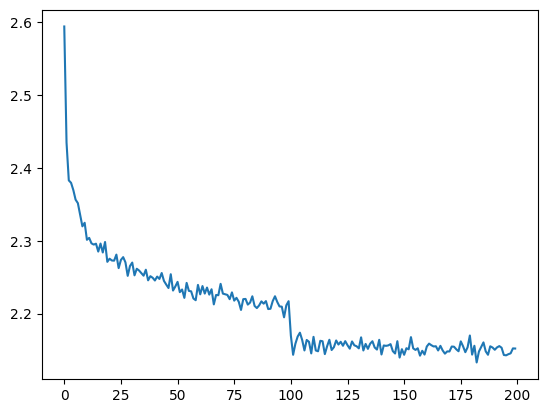

In [69]:
plt.plot(torch.tensor(losses).view(-1, 1000).mean(1))

In [70]:
# put layers into eval mode (needed for batch norm)

for layer in model.layers:
    layer.training = False


In [71]:
# evalue the loss

@torch.no_grad()

def split_loss(split):
    x,y = {
        "train" : (xtr, ytr),
        "val" : (xdev, ydev),
        "test" : (xte, yte)
    }[split]

    logits = model(x)

    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss("train")
split_loss("val")
    

train 2.117342233657837
val 2.143122911453247


In [72]:
# sample from the model

for _ in range(10):
    out = []   
    context = [0] * block_size
    
    while True:
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1).item()
        
        context = context[1:] + [ix]
        out.append(itos[ix])

        if ix == 0:
            break

    print("".join(out))


jalla.
adya.
brezer.
jaelari.
kashivu.
jatzley.
yalex.
anty.
hainaela.
nii.


In [73]:
# implementing wavenet

# build the dataset
block_size = 8

def build_dataset(words):
    x, y = [], []
    
    for w in words:
        context = [0] * block_size
        for ch in w + ".":
            ix = stoi[ch]
            x.append(context)
            y.append(ix)
            context = context[1:] + [ix]
    x = torch.tensor(x)
    y = torch.tensor(y)

    return x, y

n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

xtr, ytr = build_dataset(words[:n1])
xdev, ydev = build_dataset(words[n1:n2])
xte, yte = build_dataset(words[n2:])


In [75]:
for x, y in zip(xtr[:20], ytr[:20]):
    print("".join(itos[ix.item()] for ix in x), " --> ", itos[y.item()])

........  -->  y
.......y  -->  u
......yu  -->  h
.....yuh  -->  e
....yuhe  -->  n
...yuhen  -->  g
..yuheng  -->  .
........  -->  d
.......d  -->  i
......di  -->  o
.....dio  -->  n
....dion  -->  d
...diond  -->  r
..diondr  -->  e
.diondre  -->  .
........  -->  x
.......x  -->  a
......xa  -->  v
.....xav  -->  i
....xavi  -->  e


In [100]:
# Layer modules
from functools import reduce

g = torch.Generator().manual_seed(2147483647)

class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weights = torch.randn((fan_in, fan_out))
        self.bias = torch.randn((fan_out)) if bias else None

    def __call__(self, x):
        self.out = x @ self.weights
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        if self.bias is None:
            return [self.weights]
        return [self.weights, self.bias]
    
class BatchNorm1d:
    def __init__(self, dim, eps = 1e-5, momentum = 0.1):
        self.eps = eps
        self.momentum = momentum
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        self.training = True
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        if self.training:
            if x.ndim == 2:
                dim = 0
            elif x.ndim == 3:
                dim = (0,1)
            xmean = x.mean(dim, keepdim=True)
            xvar = x.var(dim, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var

        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta

        # update the buffers:
        if self.training:
            self.running_mean = self.momentum * xmean + (1 - self.momentum) * self.running_mean
            self.running_var = self.momentum * xvar + (1 - self.momentum) * self.running_var

        return self.out
        
    def parameters(self):
        return [self.gamma, self.beta]
    

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []
    
class Embedding:
    def __init__(self, num_emb, emb_dim):
        self.weight = torch.randn(num_emb, emb_dim)

    def __call__(self, IX):
        self.out = self.weight[IX]
        return self.out

    def parameters(self):
        return [self.weight]
    
class FlattenConsecutive:
    def __init__(self, n):
        self.n = n

    def __call__(self, x):
        B, T, C = x.shape
        self.out = x.view(B, T//self.n, C*self.n)

        if self.out.shape[1] == 1:
            self.out = self.out.squeeze(1)

        return self.out
    
    def parameters(self):
        return []
    

class Sequential:
    def __init__(self, layers):
        self.layers = layers
        self.layers[-1].weights *= 0.1

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]




In [105]:
torch.manual_seed(42)

n_emb = 10
n_hidden = 128

model = Sequential([
    Embedding(vocab_size, n_emb), 
    FlattenConsecutive(2), Linear(n_emb * 2, n_hidden, bias = False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias = False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias = False), BatchNorm1d(n_hidden), Tanh(),

    Linear(n_hidden, vocab_size)
])

parameters = model.parameters()
print("Total params : ", sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True


Total params :  72617


In [106]:
ix = torch.randint(0, xtr.shape[0], (4,))
xb, yb = xtr[ix], ytr[ix]

logits = model(xb)
print(xb.shape)


torch.Size([4, 8])


In [107]:
for layer in model.layers:
    print(layer.__class__.__name__, " : ", tuple(layer.out.shape))

Embedding  :  (4, 8, 10)
FlattenConsecutive  :  (4, 4, 20)
Linear  :  (4, 4, 128)
BatchNorm1d  :  (4, 4, 128)
Tanh  :  (4, 4, 128)
FlattenConsecutive  :  (4, 2, 256)
Linear  :  (4, 2, 128)
BatchNorm1d  :  (4, 2, 128)
Tanh  :  (4, 2, 128)
FlattenConsecutive  :  (4, 256)
Linear  :  (4, 128)
BatchNorm1d  :  (4, 128)
Tanh  :  (4, 128)
Linear  :  (4, 27)


In [108]:
# same optimization as last time

max_steps = 200000
batch_size = 32
losses = []
ud = []


for i in range(max_steps):

    # minibatch calculation
    ix = torch.randint(0, xtr.shape[0], (batch_size, ))
    xb, yb = xtr[ix], ytr[ix]

    # forward pass
    logits = model(xb)
    loss = F.cross_entropy(logits, yb)

    # backward pass
    for p in parameters:
        p.grad = None
    
    loss.backward()

    # update of parameters
    lr = 0.1 if i < 100000 else  0.01
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    losses.append(loss.item())
    ud.append([(lr*p.grad.std() / p.data.std()).log10().item() for p in parameters])

    if i % 10000 == 0:
        print(f"{i} / {max_steps} : loss = {loss:.4f}")



0 / 200000 : loss = 3.7205
10000 / 200000 : loss = 1.9745
20000 / 200000 : loss = 2.2223
30000 / 200000 : loss = 2.0242
40000 / 200000 : loss = 2.0470
50000 / 200000 : loss = 2.1469
60000 / 200000 : loss = 2.6070
70000 / 200000 : loss = 2.4516
80000 / 200000 : loss = 2.1815
90000 / 200000 : loss = 2.2008
100000 / 200000 : loss = 1.8215
110000 / 200000 : loss = 2.0038
120000 / 200000 : loss = 2.2624
130000 / 200000 : loss = 2.2221
140000 / 200000 : loss = 2.3419
150000 / 200000 : loss = 2.0710
160000 / 200000 : loss = 2.2679
170000 / 200000 : loss = 2.1266
180000 / 200000 : loss = 1.8666
190000 / 200000 : loss = 2.0216


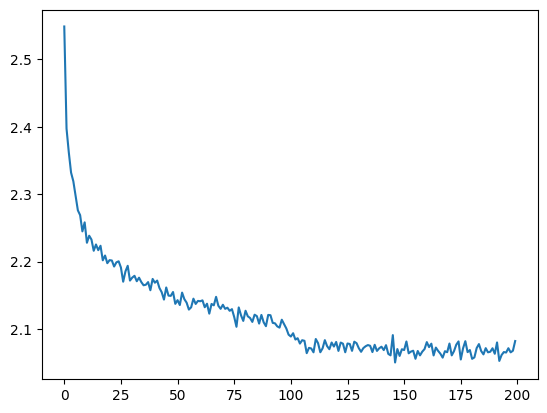

In [109]:
plt.plot(torch.tensor(losses).view(-1, 1000).mean(1))

In [110]:
# put layers into eval mode (needed for batch norm)

for layer in model.layers:
    layer.training = False


In [111]:
# evalue the loss

@torch.no_grad()

def split_loss(split):
    x,y = {
        "train" : (xtr, ytr),
        "val" : (xdev, ydev),
        "test" : (xte, yte)
    }[split]

    logits = model(x)

    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss("train")
split_loss("val")
    

train 2.0310628414154053
val 2.0847766399383545


In [112]:
# sample from the model

for _ in range(10):
    out = []   
    context = [0] * block_size
    
    while True:
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1).item()
        
        context = context[1:] + [ix]
        out.append(itos[ix])

        if ix == 0:
            break

    print("".join(out))


iluhans.
vena.
lakon.
seyon.
lairin.
pobass.
garisdy.
juchan.
danrym.
ashur.
